## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL

warnings.filterwarnings('ignore')
shap.initjs()

c:\Users\user\VSCodeProjects\flex-task\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [2]:
df = pd.read_csv('df.csv')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'])
df


,date,copper_price,buy_price,global_consumer_price_index,six_month_demand,gold_price,inventory
0,2020-01-01,3.137096,2.661115,117.999071,30.943593,2345.428509,11.721919
1,2020-02-01,3.080626,2.601521,121.141858,39.010606,2339.954887,34.574074
2,2020-03-01,3.116939,2.596875,122.787487,37.089984,1915.409552,28.794901
3,2020-04-01,3.180225,2.717195,124.483782,39.637642,2119.374158,40.498696
4,2020-05-01,3.220652,2.707316,121.855462,31.061250,2113.274844,34.927412
...,...,...,...,...,...,...,...
95,2027-12-01,3.510925,3.032640,196.290341,47.405890,2348.688526,22.279791
96,2028-01-01,3.397751,2.905826,197.409496,49.262588,2034.178653,6.486046
97,2028-02-01,3.251829,2.763559,199.246402,52.169598,1842.176256,46.331669
98,2028-03-01,3.259828,2.796132,199.289260,51.048567,2224.503966,39.992547


In [3]:
# drop 'date' column
df_without_date = df.drop('date', axis=1)
df_without_date

,copper_price,buy_price,global_consumer_price_index,six_month_demand,gold_price,inventory
0,3.137096,2.661115,117.999071,30.943593,2345.428509,11.721919
1,3.080626,2.601521,121.141858,39.010606,2339.954887,34.574074
2,3.116939,2.596875,122.787487,37.089984,1915.409552,28.794901
3,3.180225,2.717195,124.483782,39.637642,2119.374158,40.498696
4,3.220652,2.707316,121.855462,31.061250,2113.274844,34.927412
...,...,...,...,...,...,...
95,3.510925,3.032640,196.290341,47.405890,2348.688526,22.279791
96,3.397751,2.905826,197.409496,49.262588,2034.178653,6.486046
97,3.251829,2.763559,199.246402,52.169598,1842.176256,46.331669
98,3.259828,2.796132,199.289260,51.048567,2224.503966,39.992547


In [4]:
df.isna().sum()

date                           0
copper_price                   0
buy_price                      0
global_consumer_price_index    0
six_month_demand               0
gold_price                     0
inventory                      0
dtype: int64

In [5]:
df_without_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   copper_price                 100 non-null    float64
 1   buy_price                    100 non-null    float64
 2   global_consumer_price_index  100 non-null    float64
 3   six_month_demand             100 non-null    float64
 4   gold_price                   100 non-null    float64
 5   inventory                    100 non-null    float64
dtypes: float64(6)
memory usage: 4.8 KB


In [6]:
# Split data into features and target
X = df_without_date.drop('six_month_demand', axis=1)
y = df_without_date['six_month_demand']


## Data visualization

In [7]:
fig = px.line(df, x='date', y=df.columns[1:], title="Values of features over time")
fig.show()

In [8]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=df['date'], y=df['gold_price'], name='gold_price', yaxis='y2')
)

categories = df.columns.difference(['date', 'gold_price'])
for category in categories:
    fig.add_trace(
        go.Scatter(x=df['date'], y=df[category], name=category)
    )

fig.update_layout(
    xaxis=dict(title='Date'),
    yaxis=dict(title='Values except gold_price'),
    yaxis2=dict(title='Gold Price', overlaying='y', side='right'),
    title='Values of features over time',
    legend=dict(
        x=0.5,  # Horizontal position (0: left, 1: right)
        y=-1,    # Vertical position (0: bottom, 1: top)
        xanchor='center',  
        yanchor='bottom'     
    )
)

fig.show()

### Correlation between features in dataset (excluding 'date' column)

                             copper_price  buy_price  \
copper_price                     1.000000   0.997849   
buy_price                        0.997849   1.000000   
global_consumer_price_index     -0.074692  -0.069915   
six_month_demand                -0.083283  -0.079522   
gold_price                       0.012948   0.023903   
inventory                       -0.099819  -0.096886   

                             global_consumer_price_index  six_month_demand  \
copper_price                                   -0.074692         -0.083283   
buy_price                                      -0.069915         -0.079522   
global_consumer_price_index                     1.000000          0.547820   
six_month_demand                                0.547820          1.000000   
gold_price                                      0.129320          0.102640   
inventory                                       0.238538          0.473308   

                             gold_price  inventory  
copper_

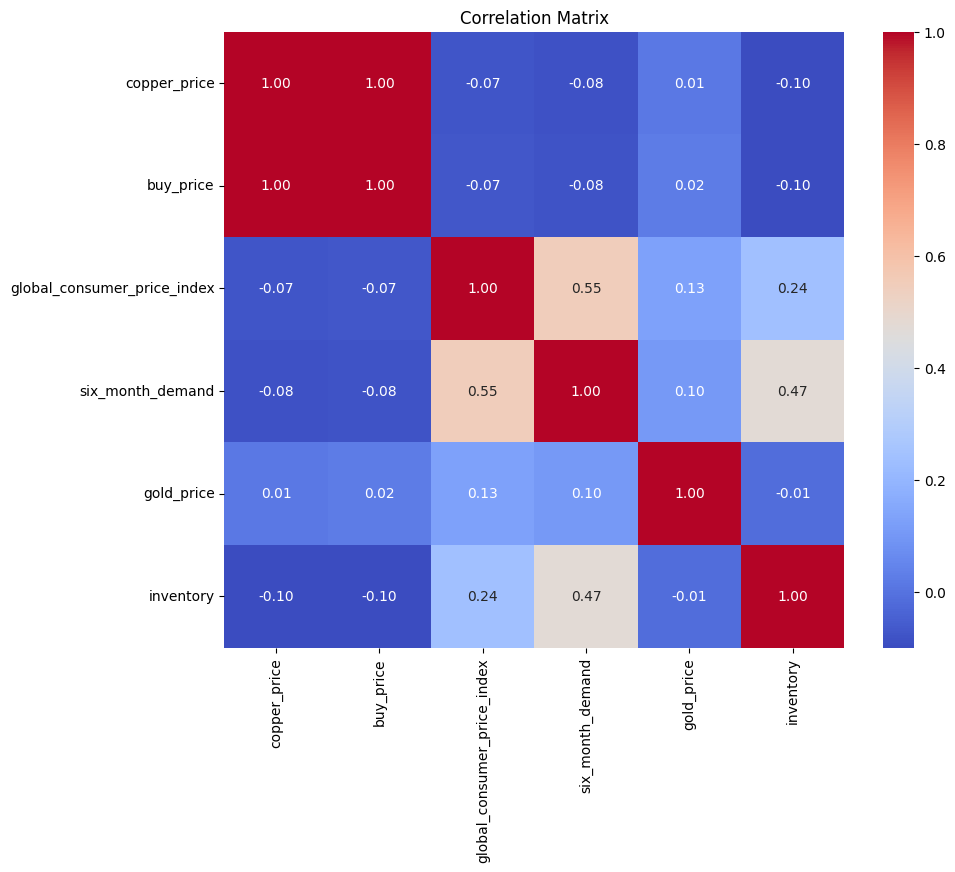

In [9]:
corr_matrix = df_without_date.corr()

# Print the correlation matrix
print(corr_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### Correlation between features over years

In [10]:
df_with_year = df.copy()
df_with_year['year'] = pd.to_datetime(df['date']).dt.year
years = df_with_year['year'].unique()

fig = make_subplots(rows=len(years), cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=[str(year) for year in years])

for i, year in enumerate(years):
    df_year = df_with_year[df_with_year['year'] == year]
    
    to_drop = ['year', 'date']
    corr_matrix = df_year.drop(to_drop, axis=1).corr()
    
    heatmap = go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='viridis',
        zmin=-1, zmax=1,
        showscale=True,
        ygap=2,
        xgap=2
    )
    
    fig.add_trace(heatmap, row=i+1, col=1)

fig.update_layout(
    height=1000 * len(years),
    title='Correlation Matrix for Each Year',
    showlegend=True
)

fig.show()

## Data seasonality

In [30]:
def plot_components(result, model_name):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition using ' + model_name,
      xaxis_title='Time',
      height=1200,
      width=1200
  )

  fig.show()

### *seasonal_decompose*

In [34]:
decomposition = seasonal_decompose(df['six_month_demand'], period=12)
plot_components(decomposition, 'seasonal_decompose')

### *STL*

In [35]:
stl = STL(df['six_month_demand'], period=12)
result_stl = stl.fit()

plot_components(result_stl, 'STL')

### *MSTL*

In [54]:
mstl = MSTL(df['six_month_demand'], periods=[12, 48])
result_mstl = mstl.fit()

# Plot the results
plot_components(result_mstl, 'MSTL')

## Preparing data for training

In [15]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (80, 5)
X_test shape: (20, 5)


## Feature selection

### Correlation Coefficient

In [16]:
# Check the correlation between the features and 'six_month_demand' column
corr = df_without_date.corr()
corr['six_month_demand'].sort_values(ascending=False)

six_month_demand               1.000000
global_consumer_price_index    0.547820
inventory                      0.473308
gold_price                     0.102640
buy_price                     -0.079522
copper_price                  -0.083283
Name: six_month_demand, dtype: float64

### RandomForestRegressor

In [17]:
rf = RandomForestRegressor(n_estimators=250, random_state=42)

rf.fit(X_train, y_train)
importances = rf.feature_importances_

# Create a DataFrame for visualizing feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

                       Feature  Importance
2  global_consumer_price_index    0.381484
4                    inventory    0.294753
3                   gold_price    0.149113
0                 copper_price    0.094397
1                    buy_price    0.080253


## *RandomForestRegressor* training

In [18]:
rf_regressor = RandomForestRegressor(n_estimators=250, max_depth=7, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=250, random_state=42)

In [19]:
y_pred_rf = rf_regressor.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
accuracy_rf = rf_regressor.score(X_test, y_test)

print(f'Mean Squared Error value: {mse_rf:.2f}')
print(f'R-squared value: {r2_rf:.2f}')
print(f'Accuracy: {accuracy_rf:.2f}')

feature_importances_rf = rf_regressor.feature_importances_
print('Feature importance: ', feature_importances_rf)

Mean Squared Error value: 15.83
R-squared value: 0.74
Accuracy: 0.74
Feature importance:  [0.09654849 0.07629923 0.38311512 0.14816273 0.29587444]


### eXplainable AI to determine influence of each variable on the output

In [20]:
explainer_rf = shap.Explainer(rf_regressor)
shap_values_rf = explainer_rf.shap_values(X_test)

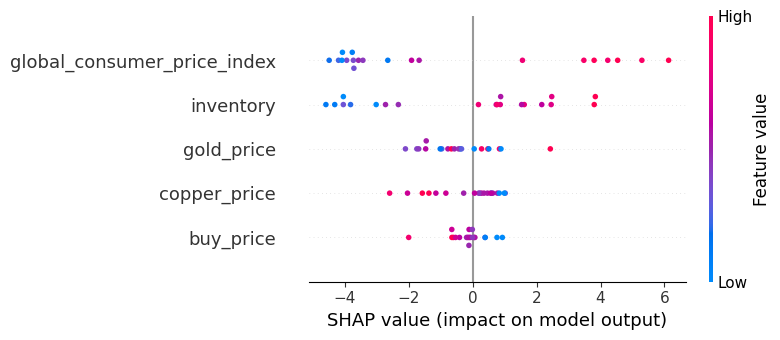

In [21]:
shap.summary_plot(shap_values_rf, X_test, feature_names=X.columns)

## *GradientBoostingRegressor* training

In [22]:
gbr=GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.005,
    random_state=42,
    max_features=5, 
    criterion='squared_error', 
    loss='squared_error', 
    subsample=0.4)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.005,
                          max_features=5, n_estimators=600, random_state=42,
                          subsample=0.4)

In [23]:
y_pred_gbr = gbr.predict(X_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)
accuracy_gbr = gbr.score(X_test, y_test)

print(f'Mean Squared Error value: {mse_gbr:.2f}')
print(f'R-squared value: {r2_gbr:.2f}')
print(f'Accuracy: {accuracy_gbr:.2f}')

feature_importances_gbr = gbr.feature_importances_
print('Feature importance: ', feature_importances_gbr)

Mean Squared Error value: 14.32
R-squared value: 0.77
Accuracy: 0.77
Feature importance:  [0.10492427 0.09539888 0.34376545 0.19149915 0.26441225]


### eXplainable AI to determine influence of each variable on the output

In [24]:
explainer_gbr = shap.Explainer(gbr)
shap_values_gbr = explainer_gbr.shap_values(X_test)

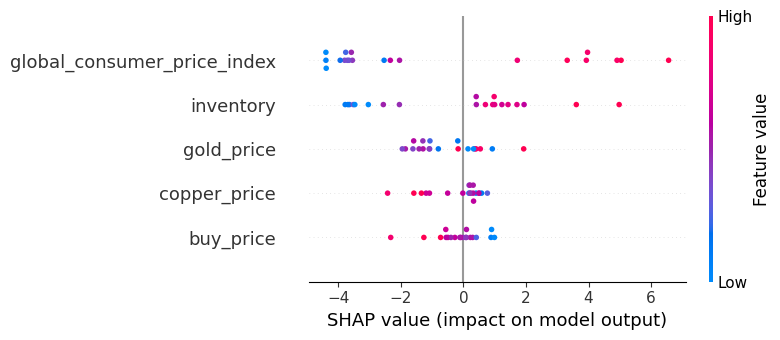

In [25]:
shap.summary_plot(shap_values_gbr, X_test, feature_names=X.columns)

## Compare model outputs

In [26]:
feature_importances_rf = pd.Series(rf_regressor.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances_gbr = pd.Series(gbr.feature_importances_, index=X.columns).sort_values(ascending=False)

In [27]:
# Create a combined DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_importances_gbr.index,
    'Gradient Boosting': feature_importances_gbr.values,
    'Random Forest': feature_importances_rf[feature_importances_gbr.index].values
})

# Create a grouped bar chart for feature importances
fig = go.Figure()

fig.add_trace(go.Bar(
    x=feature_importances_df['Feature'],
    y=feature_importances_df['Gradient Boosting'],
    name='Gradient Boosting',
    marker=dict(color='blue')
))

fig.add_trace(go.Bar(
    x=feature_importances_df['Feature'],
    y=feature_importances_df['Random Forest'],
    name='Random Forest',
    marker=dict(color='orange')
))

# Update layout
fig.update_layout(
    barmode='group',
    height=600,
    width=1000,
    title='Feature Importances: Gradient Boosting vs Random Forest',
    xaxis_title='Features',
    yaxis_title='Importance',
    showlegend=True
)

# Show the figure
fig.show()

In [28]:
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'R²', 'Accuracy'],
    'Gradient Boosting Regressor': [mse_gbr, r2_gbr, accuracy_gbr],
    'Random Forest Regressor': [mse_rf, r2_rf, accuracy_rf]
})

print(comparison_df)

     Metric  Gradient Boosting Regressor  Random Forest Regressor
0       MSE                    14.317085                15.827571
1        R²                     0.767142                 0.742575
2  Accuracy                     0.767142                 0.742575
